In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import utils
import math

dataDir = "c:/Users/llave/Documents/CMS/data/electron_selection_compressed/"

Using TensorFlow backend.


In [20]:
nE=0
nE_empty = 0
e_max = []
for file in os.listdir(dataDir):
    if("e_0p25"in file and ".npz" in file):
        
        # load images from file
        temp = np.load(dataDir+file)
        if(len(temp['images'])>0): e_images = temp['images']
        
        # reshape images
        e_images = e_images[:,1:]
        if(e_images.shape[1] != 6400):
            print(file)
            continue
        e_images = np.reshape(e_images,(e_images.shape[0],40,40,4))
        e_images = e_images[:,:,:,0]
        
        # store indices for max of each ECAL image
        for img in e_images:
            tempMax = []
            for i in range(3):
                if(img.max()==0): 
                    nE_empty+=1
                    break
                indices = np.where(img == img.max())
                if(len(indices[0]) > 1):
                    indices =  np.array([indices[0][0],indices[1][0]])
                tempMax.append(indices)
                img[indices] = 0
            if(len(tempMax)==3): e_max.append(tempMax)
       
        nE+=e_images.shape[0]

e_0p25_1131.npz
e_0p25_17.npz
e_0p25_2222.npz
e_0p25_2893.npz
e_0p25_87.npz


In [3]:
nBkg=0
nBkg_empty = 0
bkg_max = []
nSaved = 0
for file in os.listdir(dataDir):
    if("bkg_"in file and ".npz" in file):
        
        # load images from file
        temp = np.load(dataDir+file)
        if(len(temp['images'])>0): bkg_images = temp['images']
            
        # reshape images
        bkg_images = bkg_images[:,1:]
        bkg_images = np.reshape(bkg_images,(bkg_images.shape[0],40,40,4))
        bkg_images = bkg_images[:,:,:,0]
        
        # store indices for max of each ECAL image
        for img in bkg_images:
            tempMax = []
            for i in range(3):
                if(img.max() == 0): 
                    nBkg_empty+=1
                    break
                indices = np.where(img == img.max())
                if(len(indices[0]) > 1):
                    indices =  np.array([indices[0][0],indices[1][0]])
                tempMax.append(indices)
                img[indices] = 0
            if(len(tempMax)==3): bkg_max.append(tempMax)
        
        nBkg+=bkg_images.shape[0]
        nSaved+=1
        if(nSaved%20==0): print(nSaved)
        if(nSaved == 100): break

20
40
60
80
100


In [4]:
veti = np.arange(0,30)
bkg_failVeto, bkg_passVeto = np.zeros(len(veti)), np.zeros(len(veti))
e_failVeto, e_passVeto = np.zeros(len(veti)), np.zeros(len(veti))
for i,veto in enumerate(veti):
    
    for img in bkg_max:
        failVeto = False
        for pixel in img:
            if(math.sqrt(pow(pixel[0]-19.5,2)+pow(pixel[1]-19.5,2)) >= veto): 
                failVeto = True
        if(failVeto): bkg_failVeto[i]+=1
        else: bkg_passVeto[i] +=1
    
    for img in e_max:
        failVeto = False
        for pixel in img:
            if(math.sqrt(pow(pixel[0]-19.5,2)+pow(pixel[1]-19.5,2)) >= veto): 
                failVeto = True
        if(failVeto): e_failVeto[i]+=1
        else: e_passVeto[i] +=1

In [21]:
print(len(bkg_max), nBkg_empty, nBkg)
print(len(e_max), nE_empty, nE)
f_bkg_failVeto = bkg_failVeto/len(bkg_max)
f_bkg_passVeto = bkg_passVeto/len(bkg_max)
f_e_failVeto = e_failVeto/len(e_max)
f_e_passVeto = e_passVeto/len(e_max)

127252 241135 368387
17657 137 17794


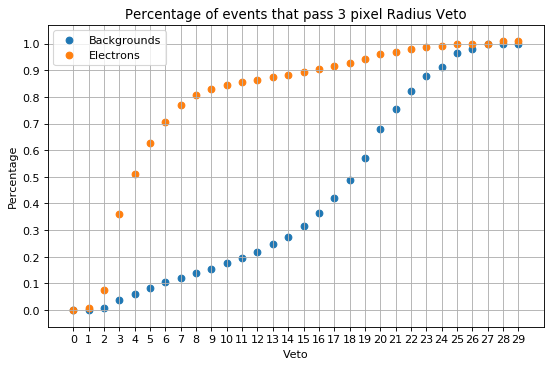

In [22]:
%matplotlib inline
#plt.scatter(veti, bkg_failVeto, label="Backgrounds that fail the Veto")
plt.figure(figsize=(8, 5), dpi=80)
plt.scatter(veti, f_bkg_passVeto, label="Backgrounds")
#plt.scatter(veti, e_failVeto, label="Electrons that fail the Veto")
plt.scatter(veti, f_e_passVeto, label="Electrons")
plt.title("Percentage of events that pass 3 pixel Radius Veto")
plt.xlabel("Veto")
plt.ylabel("Percentage")
plt.xticks(np.arange(0,30,1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.legend()

In [187]:
nTotE = nEMax0 + np.sum(e_max)
print(nEMax0*1.0/nTotE, nEMax0)
print(f_e_failVeto[20], e_failVeto[20])

0.007024839833651793 125
0.015054615428151 266.0


In [188]:
nTotBkg = nBkgMax0 + np.sum(bkg_max)
print(nBkgMax0*1.0/nTotBkg, nBkgMax0)
print(f_bkg_failVeto[20], bkg_failVeto[20])

0.1923062085657439 363902
0.10190309754691662 155749.0


In [11]:
veti = np.arange(0,30)
e_passDVeto, e_failDVeto = np.zeros(len(veti)), np.zeros(len(veti))
bkg_passDVeto, bkg_failDVeto = np.zeros(len(veti)), np.zeros(len(veti))
for i,veto in enumerate(veti):
    for img in bkg_max:
        failVeto = False
        a = math.sqrt(pow(img[0][0]-img[1][0], 2)+pow(img[0][1]-img[1][1],2)) 
        b = math.sqrt(pow(img[0][0]-img[2][0], 2)+pow(img[0][1]-img[2][1],2)) 
        c = math.sqrt(pow(img[1][0]-img[2][0], 2)+pow(img[1][1]-img[1][1],2)) 
        d = np.mean([a,b,c])
        
        if(d >= veto): bkg_failDVeto[i]+=1
        else: bkg_passDVeto[i] +=1
            
    for img in e_max:
        failVeto = False
        a = math.sqrt(pow(img[0][0]-img[1][0], 2)+pow(img[0][1]-img[1][1],2)) 
        b = math.sqrt(pow(img[0][0]-img[2][0], 2)+pow(img[0][1]-img[2][1],2)) 
        c = math.sqrt(pow(img[1][0]-img[2][0], 2)+pow(img[1][1]-img[1][1],2)) 
        d = np.mean([a,b,c])
        
        if(d >= veto): e_failDVeto[i]+=1
        else: e_passDVeto[i] +=1

In [12]:
print(len(bkg_max), nBkg_empty, nBkg)
print(len(e_max), nE_empty, nE)
f_bkg_failDVeto = bkg_failDVeto/len(bkg_max)
f_bkg_passDVeto = bkg_passDVeto/len(bkg_max)
f_e_failDVeto = e_failDVeto/len(e_max)
f_e_passDVeto = e_passDVeto/len(e_max)

127252 241135 368387
17794 392 17794


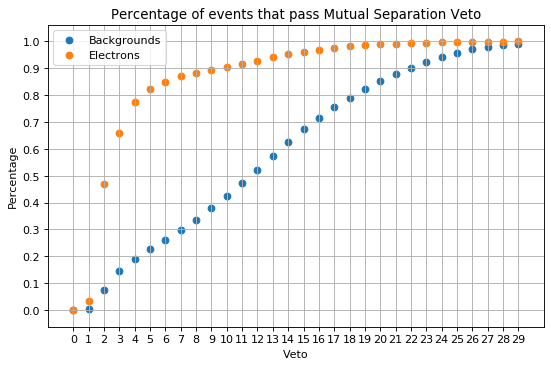

In [13]:
%matplotlib inline
#plt.scatter(veti, bkg_failVeto, label="Backgrounds that fail the Veto")
plt.figure(figsize=(8, 5), dpi=80)
plt.scatter(veti, f_bkg_passDVeto, label="Backgrounds")
#plt.scatter(veti, e_failVeto, label="Electrons that fail the Veto")
plt.scatter(veti, f_e_passDVeto, label="Electrons")
plt.title("Percentage of events that pass Mutual Separation Veto")
plt.xlabel("Veto")
plt.ylabel("Percentage")
plt.xticks(np.arange(0,30,1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.legend()